In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('restaurant_reviews.tsv',sep='\t')
print(f'The no. of data points is {len(data)}')
print(data['Liked'].value_counts())

The no. of data points is 1000
1    500
0    500
Name: Liked, dtype: int64


In [3]:
import re

def de_html(target):
    filtered = re.sub(r'<.*>',' ',target)
    return filtered

def de_special_chars(target):
    cleaned = re.sub(r'[?|!|\'|"|#|$|@|&|%]',' ',target)
    cleaned = re.sub(r'[.|,|)|(|\\|/]',' ',cleaned)
    return cleaned

In [4]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [5]:
negative_words = []
positive_words = []
cleaned_data = []
review_count = 0

for review in data['Review']:
    cleaned_review = []
    review = de_html(review)
    review = de_special_chars(review)
    for word in review.split():
        if word.lower() not in stop_words:
            if word.isalpha() and len(word) > 2:
                if data.iloc[review_count,-1]:
                    positive_words.append(word.lower())
                else:
                    negative_words.append(word.lower())
                stemmed_word = stemmer.stem(word.lower())
                cleaned_review.append(stemmed_word)
    cleaned_review = ' '.join(cleaned_review)
    cleaned_data.append(cleaned_review)
    review_count += 1


In [6]:
from nltk import FreqDist
frequency = FreqDist(positive_words)
print(frequency.most_common(10))

[('good', 73), ('great', 70), ('food', 60), ('place', 57), ('service', 45), ('friendly', 24), ('delicious', 23), ('back', 23), ('amazing', 22), ('nice', 22)]


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
word_model = CountVectorizer(binary=True)
bag_of_words = word_model.fit_transform(cleaned_data)
target_labels = data.iloc[:,-1].values

In [22]:
from sklearn.model_selection import train_test_split
ind_train,ind_test,dep_train,dep_test = train_test_split(bag_of_words,target_labels,test_size=0.2,random_state=0)

C:\Users\SysSoft\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\SysSoft\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\SysSoft\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\SysSoft\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users

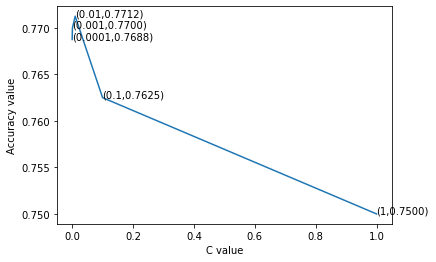

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# alpha_values = list(range(1,11))
# c_values = [1e-4,1e-3,1e-2,1e-1,1,10,100,1000,1e4]
c_values = [1e-4,1e-3,1e-2,1e-1,1]
acc_values = []

for alph in c_values:
    # model = BernoulliNB(alpha=alph)
    model = LogisticRegression(penalty='elasticnet',l1_ratio=alph,solver='saga')
    accuracy_result = cross_val_score(model,ind_train,dep_train,cv=10,scoring='accuracy')
    acc_values.append(accuracy_result.mean())

plt.plot(c_values,acc_values)

for alph,acc in list(zip(c_values,acc_values)):
    plt.annotate(f'({alph},{acc:.4f})',xy=(alph,acc))

plt.xlabel('C value')
plt.ylabel('Accuracy value')
plt.show()

In [34]:
print(acc_values.index(max(acc_values)))

2


In [31]:
# model = BernoulliNB(alpha=3)
model = LogisticRegression(penalty='elasticnet',l1_ratio=0.01,solver='saga')
model.fit(ind_train,dep_train)
results = model.predict(ind_test)

In [32]:

from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
matrix = confusion_matrix(dep_test,results)
accuracy_score = accuracy_score(dep_test,results)

probs_result = model.predict_proba(ind_test)
max_label_probs = probs_result[:,1]
    
auc_score = roc_auc_score(dep_test,max_label_probs)

print(f'The confusion matrix looks like:\n {matrix}')
print(f'The accuracy score is {accuracy_score}')
print(f'The AUC score is {auc_score}')

The confusion matrix looks like:
 [[70 27]
 [37 66]]
The accuracy score is 0.68
The AUC score is 0.8110299269342408


In [ ]:
#BOW, bernoulliNB(alpha =3), unigrams,bigrams:
# The confusion matrix looks like:
#  [[81 16]
#  [26 77]]
# The accuracy score is 0.79
# The AUC score is 0.8529676709038134
